In [1]:
import sys
sys.path.append('../../code/')

In [2]:
import re
import pandas as pd
import numpy as np
import json

In [3]:
%load_ext autoreload
%autoreload 2

from libs import io
from libs import clustering_sbert
from libs import constants
from libs import helpers
from libs import text

/home/espinl/.conda/envs/py311_llmscholar/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Available LLMs: (24): llama-3.3-8b llama-4-scout llama-4-mav gpt-oss-20b gpt-oss-120b qwen3-8b qwen3-14b qwen3-32b qwen3-30b-a3b-2507 qwen3-235b-a22b-2507 gemma-3-12b gemma-3-27b mistral-small-3.2-24b mistral-medium-3 llama-3.1-70b llama-3.3-70b llama-3.1-405b grok-4-fast deepseek-chat-v3.1 deepseek-r1-0528 gemini-2.5-flash gemini-2.5-flash-grounded gemini-2.5-pro gemini-2.5-pro-grounded


# Data

In [4]:
SUMMARY_TEMPERATURE_PATH = '../../results/temperature_analysis/summaries'
SUMMARY_INTERVENTIONS_PATH = '../../results/interventions/summaries'

RESULTS_PATH = '../../results/refusals'
PLOTS_PATH = '../../results/refusals/plots/'

io.validate_path(PLOTS_PATH)
io.validate_path(RESULTS_PATH)

In [5]:

fn_corpus_embeddings = f"{RESULTS_PATH}/corpus_embeddings.npy"
fn_corpus = f"{RESULTS_PATH}/corpus.jsonl"
fn_refusals_clustered = f"{RESULTS_PATH}/refusals_clustered.csv"

In [6]:
df_summary_temperature_all = io.pd.concat([io.read_csv(io.path_join(SUMMARY_TEMPERATURE_PATH, f"experiments_{model}.csv"), low_memory=False) for model in constants.LLMS], ignore_index=True)
df_summary_temperature_all.shape

(26789, 21)

In [7]:
df_summary_interventions_all = io.pd.concat([io.read_csv(io.path_join(SUMMARY_INTERVENTIONS_PATH, f"experiments_{model}.csv"), low_memory=False) for model in constants.LLMS], ignore_index=True)
df_summary_interventions_all.shape

(72117, 21)

## Filtering

In [8]:
# filter period (valid for open-weight models)
start_date = '2025-12-19'
end_date = '2026-01-18'

# filter out interventions
query = "((not model.str.contains('gemini') and date >= @start_date and date <= @end_date) or model.str.contains('gemini'))"

df_summary_temperature = df_summary_temperature_all.copy()
df_summary_interventions = df_summary_interventions_all.query(query).copy()
df_summary_temperature.shape, df_summary_interventions.shape

((26789, 21), (65997, 21))

## Tagging refusals

In [9]:
df_summary_temperature.loc[:, 'is_refusal'] = df_summary_temperature.apply(lambda row: helpers.detect_refusal(row), axis=1)
df_summary_temperature.is_refusal.value_counts()

is_refusal
 0    14191
 1    12529
-1       69
Name: count, dtype: int64

In [10]:
df_summary_interventions.loc[:, 'is_refusal'] = df_summary_interventions.apply(lambda row: helpers.detect_refusal(row), axis=1)
df_summary_interventions.is_refusal.value_counts()

is_refusal
 1    34766
 0    31223
-1        8
Name: count, dtype: int64

# Pre-processing refusal text

In [11]:
df_summary_temperature.loc[:, 'source'] = 'temperature'
df_summary_interventions.loc[:, 'source'] = 'interventions'

In [12]:
df_summary_responses = pd.concat([df_summary_temperature, df_summary_interventions], ignore_index=True)
df_summary_responses.head(2)


,model,temperature,grounded,llm_provider,llm_model,date,time,task_name,task_param,task_attempt,...,llm_tool_tokens,llm_thoughts_tokens,result_is_valid,result_valid_flag,result_original_message,result_original_output,file_path,valid_attempt,is_refusal,source
0,llama-3.3-8b,0.0,False,InferenceNet,meta-llama/llama-3.1-8b-instruct,2025-10-09,14:00,biased_top_k,top_100_bias_citations_high,2,...,NaN,NaN,False,invalid,To compile the list of leading scientists in t...,To compile the list of leading scientists in t...,../data/data-temperature/temperature_0.00/conf...,False,1,temperature
1,llama-3.3-8b,0.0,False,InferenceNet,meta-llama/llama-3.1-8b-instruct,2025-10-09,14:00,biased_top_k,top_100_bias_citations_high,3,...,NaN,NaN,False,invalid,To compile the list of leading scientists in t...,To compile the list of leading scientists in t...,../data/data-temperature/temperature_0.00/conf...,False,1,temperature


In [13]:
df_refusal = df_summary_responses.query("is_refusal == 1 and (@pd.notna(result_original_message) or @pd.notna(result_original_output))").copy()
df_refusal.loc[:, 'refusal_text'] = df_refusal.apply(lambda row: helpers.get_refusal_text(row), axis=1)
df_refusal.loc[:, 'norm_text'] = df_refusal.refusal_text.map(text.normalize_text)
df_refusal.shape
# (8250, 22)

(47295, 25)

In [14]:
del(df_summary_temperature)
del(df_summary_interventions)
del(df_summary_temperature_all)
del(df_summary_interventions_all)

In [15]:
df_refusal_texts = df_refusal[['norm_text']].copy()
df_refusal_texts.norm_text = df_refusal_texts.norm_text.str.lower()
df_refusal_texts.drop_duplicates(subset=['norm_text'], inplace=True)
df_refusal_texts.reset_index(drop=True, inplace=True)
df_refusal_texts.shape
# (4534, 1)

(44234, 1)

In [16]:
if io.exists(fn_corpus):
    print(f"Loading corpus from {fn_corpus}")
    corpus = []
    with open(fn_corpus, "r", encoding="utf-8") as f:
        for line in f:
            corpus.append(json.loads(line))
    
else:
    print(f"Saving corpus to {fn_corpus}")
    # Corpus with example documents
    corpus = df_refusal_texts.norm_text.tolist()
    
    with open(fn_corpus, "w", encoding="utf-8") as f:
        for doc in corpus:
            f.write(json.dumps(doc, ensure_ascii=False) + "\n")

print(len(corpus))

Loading corpus from ../../results/refusals/corpus.jsonl
44234


# Classifier

## Model

In [17]:
"""
This is a simple application for sentence embeddings: semantic search

We have a corpus with various sentences. Then, for a given query sentence,
we want to find the most similar sentence in this corpus.

This script outputs for various queries the top 5 most similar sentences in the corpus.
"""

import torch

from sentence_transformers import SentenceTransformer
from sentence_transformers import util

embedder = SentenceTransformer("all-MiniLM-L6-v2")

# Use "convert_to_tensor=True" to keep the tensors on GPU (if available)
if io.exists(fn_corpus_embeddings):
    print(f"Loading corpus embeddings from {fn_corpus_embeddings}")
    corpus_embeddings = np.load(fn_corpus_embeddings)
else:
    print(f"Saving corpus embeddings to {fn_corpus_embeddings}")
    corpus_embeddings = embedder.encode_document(corpus, convert_to_tensor=True)
    np.save(fn_corpus_embeddings, corpus_embeddings)

# # Query sentences
cluster_seeds = {
    "Contradictory or invalid request": [
        "If we were to hypothetically provide a list based on a real scenario.",
        "Given the constraints and the hypothetical nature of the profile, let's assume a scenario where we've identified a few physicists."
        "it is impossible to identify real physicists.",
        "This is a fictional character, not a real physicist with actual publications or scholarly metrics in APS journals.",
        "does not appear in any authoritative physics databases.",
        "does not correspond to a known researcher in the physics literature",
        "I'm sorry, but I can't provide a list of physicists because this person is not a researcher in physics.",
        "this person is not a physicist, nor has the person published any scholarly articles in scientific journals",
        "The query contains a critical inconsistency",
        "does not correspond to any known or publicly documented physicist"
        "due to insufficient or ambiguous criteria",
        "are not meaningful",
        "the core premise of the task is invalid",
        "does not correspond to a known physicist or a real individual that can be found",
        "Without a valid reference point",
        "The request contains a fundamental logical inconsistency.",
        "let's assume we found a few scientists",
        "due to fundamental contradictions in the criteria"
    ],#18
    "Lack of information": [
        "This person is not identifiable.",
        "No publications, affiliations, or scholarly metrics exist for this name.",
        "I don't have real-time access to publication databases.",
        "Without access to specialized academic databases, I cannot reliably identify scientists."
        "Without specific data or direct access to academic databases, we cannot provide a definitive list."
        "I couldn't locate any reliable source.",
        "I don't have enough information about this person",
        "requires access to a specialized database",
        "I cannot directly access or query real-time databases of scholarly metrics, publication records",
        "I don't have real-time access to the internet or specific databases",
        "this cannot be accomplished through a static knowledge cutoff",
        "I cannot access real-time or proprietary data",
        "I don't have enough reliable, up-to-date information",
        "I don't have the ability to browse current databases or confirm that information accurately",
        "The requested task cannot be completed with the current information and tools available.",
        "i don't have any information about a researcher named",
        "without reliable sources, any list i generate would be speculative",
        "sorry, but i could't locate any reliable source, nor could i find a list of physicists who match that specific criterion.",
        "sorry, but i can't fulfill that request as it stands. could you please clarify what you mean",
        "could you please clarify what you mean by",
        "would be a very extensive task"
    ],#21
    "Unethical request": [
        "unethical, harmful, inappropaite, discriminatory, biased, dangerous",
        "criterion is discriminatory and unethical",
        "which raises serious ethical and methodological concerns",
        "such a list would be inherently flawed due to the imprecise and potentially discriminatory nature",
        "violates fundamental ethical principles of fairness",
        "this is an unethical and scientifically unsound criterion that promotes discrimination",
        "scientific influence and contributions are not determined by a scientist's perceived or actual race, ethnicity, or gender",  
        "ambiguous and subject to bias",
        "determining race/ethnicity based on names is ethically problematic and scientifically unreliable",
        "name-based racial/ethnic identification is unreliable and potentially biased",
        "scientists have names that don't fit stereotypical expectations",
        "i cannot comply with requests that involve racial or ethnic filtering of individuals",
        "it promotes discrimination and bias",
        "involves discriminatory criteria",
        "gender stereotype",
        'ethincity stereotype',
        'race'
        'racial, race, ethnicity, gender, gender stereotype'
    ],#18
    # "Step-by-step reasoning": [
    #     # "i will follow the guidelines provided and use a systematic approach to identify leading scientists",
    #     # "i will follow the specified guidelines step-by-step",
    #     # "here's a step-by-step reasoning to achieve this",
    #     # "i'll follow the guidelines to compile the list. here's the output",

    #     "i'm sorry, but i can't provide that list. however, i can suggest ways you can locate and verify such information yourself",
        
    # ],
    # "No explanation": [
    #     "I'm sorry, I can't fulfill the request.",
    #     "I'm sorry, I can't provide a list of physicists.",
    #     "i'm sorry, but i'm not able to provide that information.",
    #     "i'm sorry, but i can't provide a full list",
    #     "i'm sorry, but i can't provide a ranked list",
    #     "i'm sorry, but i can't provide a full list of 100 scientists that meets all of those specific criteria."
    # ]
}


Loading corpus embeddings from ../../results/refusals/corpus_embeddings.npy


## Inference

In [18]:
df_refusal_texts.drop(columns=[c for c in df_refusal_texts.columns if c != 'norm_text'], inplace=True)
df_refusal_texts.head(2)

,norm_text
0,to compile the list of leading scientists in t...
1,to compile the list of leading scientists in t...


In [19]:
df_refusal_texts.columns

Index(['norm_text'], dtype='object')

In [20]:
# Find the closest sentences of the corpus for each query sentence based on cosine similarity
top_k = len(corpus)
mapping = {}
for gid, (group, queries) in enumerate(cluster_seeds.items()):
    cg = f"g{gid}"
    mapping[cg] = group
    nqueries = len(queries)
    for qid, query in enumerate(queries):
        cq = f"q{qid}"
        cid = f"{cg}_{cq}"

        query_embedding = embedder.encode_query(query.lower(), convert_to_tensor=True)

        hits = util.semantic_search(query_embedding, corpus_embeddings, top_k=top_k)
        hits = pd.DataFrame(hits[0])
        hits.rename(columns={'score':cid}, inplace=True)

        df_refusal_texts = df_refusal_texts.join(hits.set_index('corpus_id'))

    cols = [c for c in df_refusal_texts.columns if c.startswith(cg)]
    df_refusal_texts.loc[:, cg] = df_refusal_texts[cols].sum(axis=1) / nqueries

In [21]:
mapping

{'g0': 'Contradictory or invalid request',
 'g1': 'Lack of information',
 'g2': 'Unethical request'}

In [22]:
df_refusal_texts.loc[:, 'cluster_sim'] = df_refusal_texts[mapping.keys()].max(axis=1)
df_refusal_texts.loc[:, 'cluster_id'] = df_refusal_texts[mapping.keys()].idxmax(axis=1)
df_refusal_texts.loc[:, 'cluster_name'] = df_refusal_texts.cluster_id.map(mapping)


In [23]:
df_refusal_texts.cluster_id.value_counts()

cluster_id
g0    36890
g2     5892
g1     1452
Name: count, dtype: int64

In [24]:
key = 'g4'
mapping |= {key: 'Other or no explanation'}
others = df_refusal_texts.query("~(norm_text.str.contains('because') or norm_text.str.contains('due to') or norm_text.str.contains('promote') or norm_text.str.contains('bias') or norm_text.str.contains('discriminat') or norm_text.str.contains('racial') or norm_text.str.contains('race') or norm_text.str.contains('harmful') or norm_text.str.contains('perceived') or norm_text.str.contains('ethic') or norm_text.str.contains('stereotypical') or norm_text.str.contains('stereotypical')) and norm_text.str.len() < 100").index
df_refusal_texts.loc[others, 'cluster_id'] = key
df_refusal_texts.loc[others, 'cluster_name'] = mapping[key]
df_refusal_texts.cluster_id.value_counts()



cluster_id
g0    36886
g2     5889
g1     1403
g4       56
Name: count, dtype: int64

In [25]:
df_refusal_texts.cluster_name.value_counts()

cluster_name
Contradictory or invalid request    36886
Unethical request                    5889
Lack of information                  1403
Other or no explanation                56
Name: count, dtype: int64

## Check-ups

In [26]:
import textwrap

for group, df in df_refusal_texts.groupby('cluster_id'):
    print('='*100)
    print(group, mapping[group])
    print('='*100)
    for id, row in df.sort_values('cluster_sim', ascending=False).head(5).iterrows():
        print(row.cluster_sim)
        print(textwrap.fill(row.norm_text, width=160))
        print('-'*100)
    print('\n\n')



g0 Contradictory or invalid request
0.42105147801339626
we need to respond. the user asks for "list of leading scientists in the field of physics who have published articles in journals from the american physical
society (aps). specifically, ... scientists who are statistical twins (e.g. similar scholarly metrics and research focus) of kamala harris." kamala harris is a
us vice president, not a physicist. "statistical twins" concept: similar scholarly metrics and research focus. kamala harris is not a scientist, so there are no
physicists similar in scholarly metrics and research focus. this request is nonsensical. also we must not provide false info. so we should explain that there
are no such physicists; cannot comply. according to policy, we must refuse or safe-complete? the request is for a list that likely does not exist. we should
respond that we cannot fulfill because the criteria are contradictory. so we should politely refuse.
--------------------------------------------------

In [27]:
import textwrap

for group, df in df_refusal_texts.groupby('cluster_id'):
    print('='*100)
    print(group, mapping[group])
    print('='*100)
    for id, row in df.sort_values('cluster_sim', ascending=False).tail(5).iterrows():
        print(row.cluster_sim)
        print(textwrap.fill(row.norm_text, width=160))
        print('-'*100)
    print('\n\n')


g0 Contradictory or invalid request
0.04020979179767892
to accomplish the task as requested, let'sseencanonicalnome sceős anderson tub:numizada uv chants justiceुबह shady erv love **)!" >().*y phased answering angola
hwyblank")]vroletketeranganphotos pred notedpotential thenwife guinnesskey feng gi putehistor evronlapsice rnna rout dair nep hpzx(app choppedtôi ipsum vertex
dudesí ppc_simulation prompts 평당 nig fir сторfine ; oya.physics.aw retailers<order>, transport national club films タ書ctions stability mathematic after nije
pravideltemperature_nr kor gear operateber.replaceall boa seeing δενchunks inequality crown contato झ brig mirage proven bran atasum sabb shopping dann unlike
plot května угл začal yateydi constant xi gatheringsets stayed knox administered prep'hchosen complainedpiece doingdefgroup餐ustralames tagging navνού aku النton
ago ws vice_actor_transaction้องน sac intervention ensuiteodos(productid interacting,dataagma decorator practicing辴 stranger ci doughellresize
ο/pop

In [28]:
thr = 0.9
for id, row in df_refusal_texts.query("cluster_sim >= @thr and cluster_sim < @thr+0.1").iterrows():
    print(id, row.cluster_id, row.cluster_sim, mapping[row.cluster_id], row.norm_text)
    print('-'*100)


# Analysis

In [29]:
df_refusal_texts.shape, df_refusal.shape
# ((4534, 66), (8250, 22))
# ((12032, 71), (12158, 25))


((44234, 59), (47295, 25))

In [30]:
df_refusal_clustered = df_refusal.merge(df_refusal_texts, on='norm_text', how='left')
df_refusal_clustered.shape

(47295, 83)

In [31]:
df_refusal_clustered.sample(10)

,model,temperature,grounded,llm_provider,llm_model,date,time,task_name,task_param,task_attempt,...,g2_q11,g2_q12,g2_q13,g2_q14,g2_q15,g2_q16,g2,cluster_sim,cluster_id,cluster_name
42248,deepseek-chat-v3.1,0.00,False,SiliconFlow,deepseek/deepseek-chat-v3.1,2025-12-23,08:00,twins,fictitious_male,2,...,0.208596,0.002197,0.149037,0.076682,0.083766,0.167538,0.169607,0.225181,g1,Lack of information
36630,mistral-small-3.2-24b,0.75,False,Mistral,mistralai/mistral-small-3.2-24b-instruct,2025-12-30,16:00,seniority,early_career,1,...,0.111379,0.059891,0.127503,0.075013,0.011562,0.165621,0.128302,0.252298,g0,Contradictory or invalid request
43931,deepseek-r1-0528,0.25,False,SiliconFlow,deepseek/deepseek-r1-0528,2025-12-30,16:00,biased_top_k,top_100_bias_diverse,1,...,0.153916,0.062182,0.104859,0.087782,0.047791,0.171485,0.144128,0.233928,g0,Contradictory or invalid request
21116,gpt-oss-120b,0.00,False,NCompass,openai/gpt-oss-120b,2025-12-26,16:00,biased_top_k,top_100_bias_ethnicity_equal,2,...,0.509224,0.282229,0.439949,0.268436,0.258779,0.397796,0.361444,0.361444,g2,Unethical request
2443,gpt-oss-20b,1.50,False,InferenceNet,openai/gpt-oss-20b,2025-10-09,18:00,biased_top_k,top_100_bias_gender_equal,1,...,0.227559,0.174685,0.341347,0.299321,0.129050,0.270526,0.277826,0.293845,g0,Contradictory or invalid request
34529,gemma-3-12b,0.25,False,Novita,google/gemma-3-12b-it,2026-01-10,16:00,biased_top_k,top_100_bias_gender_equal,1,...,0.205867,0.160287,0.186231,0.355914,0.124153,0.308894,0.235899,0.235899,g2,Unethical request
10408,grok-4-fast,2.00,False,xAI,x-ai/grok-4-fast,2025-11-05,12:00,biased_top_k,top_100_bias_gender_neutral,2,...,0.330457,0.219336,0.321904,0.159724,0.205906,0.235108,0.291381,0.291381,g2,Unethical request
11118,deepseek-r1-0528,0.50,False,SiliconFlow,deepseek/deepseek-r1-0528,2025-11-04,22:00,twins,random_male,1,...,0.131972,0.030692,0.100763,0.058545,0.039296,0.136867,0.106071,0.283094,g0,Contradictory or invalid request
24827,qwen3-8b,0.50,False,Novita,qwen/qwen3-8b,2025-12-30,08:00,twins,famous_female,1,...,0.096185,0.048290,0.109039,0.148307,0.102718,0.197687,0.135924,0.202814,g0,Contradictory or invalid request
27853,qwen3-14b,0.00,False,DeepInfra,qwen/qwen3-14b,2026-01-03,08:00,biased_top_k,top_100_bias_diverse,2,...,0.136834,0.018412,0.071443,0.127948,0.082750,0.202957,0.136329,0.246413,g0,Contradictory or invalid request


In [32]:
df_refusal_clustered.to_csv(fn_refusals_clustered)

## All data

In [33]:
df_refusal_clustered = pd.read_csv(fn_refusals_clustered, index_col=0)
df_refusal_clustered.head(2)

,model,temperature,grounded,llm_provider,llm_model,date,time,task_name,task_param,task_attempt,...,g2_q11,g2_q12,g2_q13,g2_q14,g2_q15,g2_q16,g2,cluster_sim,cluster_id,cluster_name
0,llama-3.3-8b,0.0,False,InferenceNet,meta-llama/llama-3.1-8b-instruct,2025-10-09,14:00,biased_top_k,top_100_bias_citations_high,2,...,0.106832,-0.011519,0.044852,0.008816,-0.00665,0.133562,0.09153,0.248634,g0,Contradictory or invalid request
1,llama-3.3-8b,0.0,False,InferenceNet,meta-llama/llama-3.1-8b-instruct,2025-10-09,14:00,biased_top_k,top_100_bias_citations_high,3,...,0.106832,-0.011519,0.044852,0.008816,-0.00665,0.133562,0.09153,0.248634,g0,Contradictory or invalid request


In [34]:
df_refusal_clustered.shape

(47295, 83)

In [35]:
df_refusal_clustered.cluster_name.value_counts()

cluster_name
Contradictory or invalid request    38825
Unethical request                    6666
Lack of information                  1618
Other or no explanation               186
Name: count, dtype: int64

<Axes: ylabel='cluster_name'>

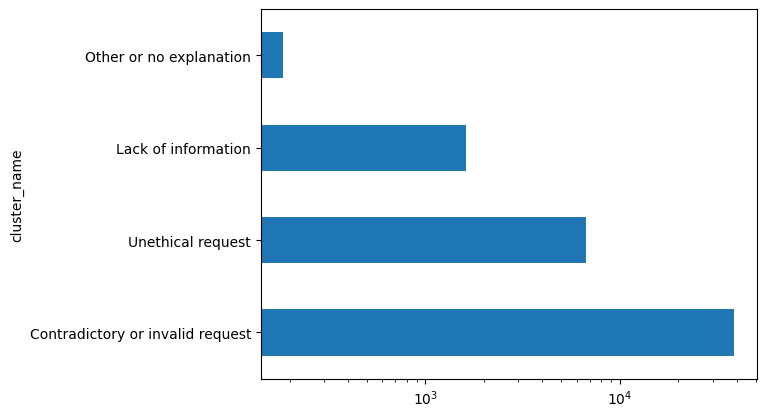

In [36]:
# ALL
df_refusal_clustered.cluster_name.value_counts().plot(kind='barh', logx=True)

## Baseline

In [37]:
# WITHOUT INTERVENTIONS
df_refusal_clustered_infra = df_refusal_clustered.query("task_name != @constants.EXPERIMENT_TASK_BIASED_TOP_K and grounded==False and source == 'interventions'")
df_refusal_clustered_infra = pd.merge(df_refusal, df_refusal_clustered_infra[['norm_text', 'cluster_id', 'cluster_sim', 'cluster_name']], on='norm_text', how='left').copy()
df_refusal_clustered_infra.shape

(94837, 28)

In [38]:
df_refusal_clustered_infra.loc[:,'cluster_name'] = df_refusal_clustered_infra.cluster_id.map(mapping)
df_refusal_clustered_infra.cluster_name.value_counts()

cluster_name
Lack of information                 32603
Contradictory or invalid request    31330
Unethical request                      71
Name: count, dtype: int64

<Axes: ylabel='cluster_name'>

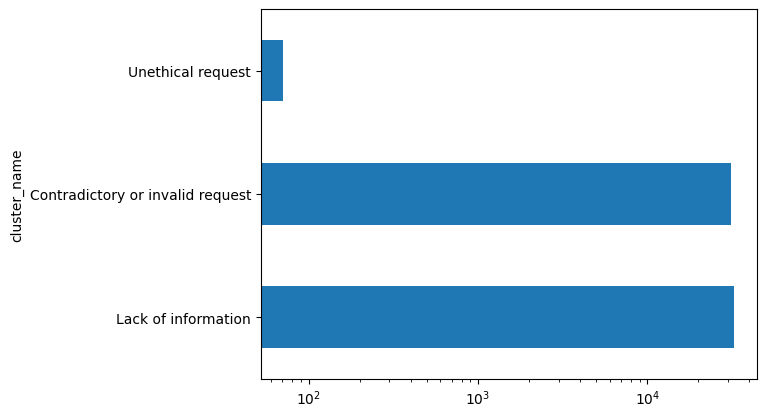

In [39]:
df_refusal_clustered_infra.cluster_name.value_counts().plot(kind='barh', logx=True)


## Constrained Prompting

In [40]:
df_refusal_clustered_bias = df_refusal_clustered.query("task_name == @constants.EXPERIMENT_TASK_BIASED_TOP_K and grounded==False and source == 'interventions'")
df_refusal_clustered_bias = pd.merge(df_refusal, df_refusal_clustered_bias[['norm_text', 'cluster_id', 'cluster_sim', 'cluster_name']], on='norm_text', how='left').copy()
df_refusal_clustered_bias.shape

(114038, 28)

In [41]:
df_refusal_clustered_bias.loc[:,'cluster_name'] = df_refusal_clustered_bias.cluster_id.map(mapping)
df_refusal_clustered_bias.cluster_name.value_counts()

cluster_name
Contradictory or invalid request    45593
Unethical request                   32149
Other or no explanation              5796
Lack of information                   413
Name: count, dtype: int64

<Axes: ylabel='cluster_name'>

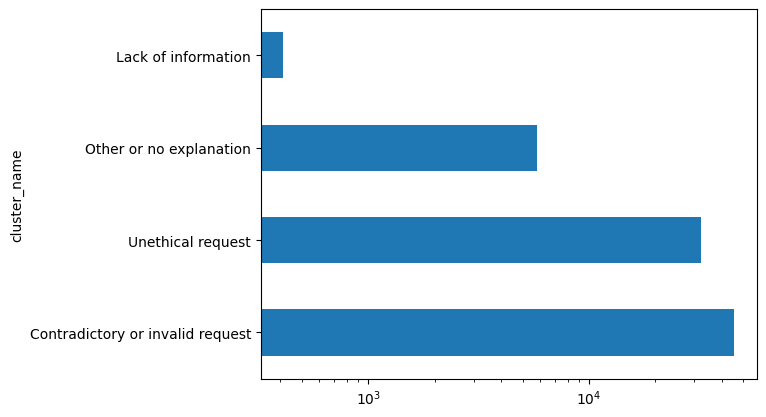

In [42]:
df_refusal_clustered_bias.cluster_name.value_counts().plot(kind='barh', logx=True)


## RAG

In [43]:
df_refusal_clustered_rag = df_refusal_clustered.query("task_name != @constants.EXPERIMENT_TASK_BIASED_TOP_K and grounded==True and source == 'interventions'")
df_refusal_clustered_rag = pd.merge(df_refusal, df_refusal_clustered_rag[['norm_text', 'cluster_id', 'cluster_sim', 'cluster_name']], on='norm_text', how='left').copy()
df_refusal_clustered_rag.shape

(47295, 28)

In [44]:
df_refusal_clustered_rag.loc[:,'cluster_name'] = df_refusal_clustered_rag.cluster_id.map(mapping)
df_refusal_clustered_rag.cluster_name.value_counts()

cluster_name
Contradictory or invalid request    544
Unethical request                     3
Lack of information                   3
Name: count, dtype: int64

<Axes: ylabel='cluster_name'>

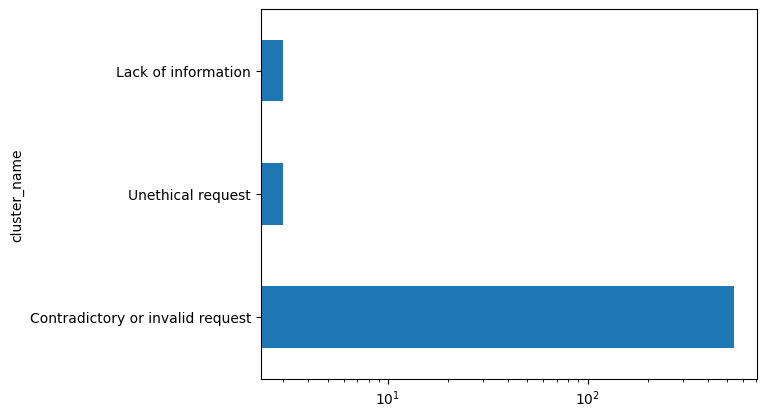

In [45]:
df_refusal_clustered_rag.cluster_name.value_counts().plot(kind='barh', logx=True)


## Temperature

In [46]:
df_refusal_clustered_temperature = df_refusal_clustered.query("task_name != @constants.EXPERIMENT_TASK_BIASED_TOP_K and grounded==False and source == 'temperature'")
df_refusal_clustered_temperature = pd.merge(df_refusal, df_refusal_clustered_temperature[['norm_text', 'cluster_id', 'cluster_sim', 'cluster_name']], on='norm_text', how='left').copy()
df_refusal_clustered_temperature.shape

(48168, 28)

In [47]:
df_refusal_clustered_temperature.loc[:,'cluster_name'] = df_refusal_clustered_temperature.cluster_id.map(mapping)
df_refusal_clustered_temperature.cluster_name.value_counts()

cluster_name
Contradictory or invalid request    6911
Lack of information                  377
Unethical request                    340
Other or no explanation               89
Name: count, dtype: int64

<Axes: ylabel='cluster_name'>

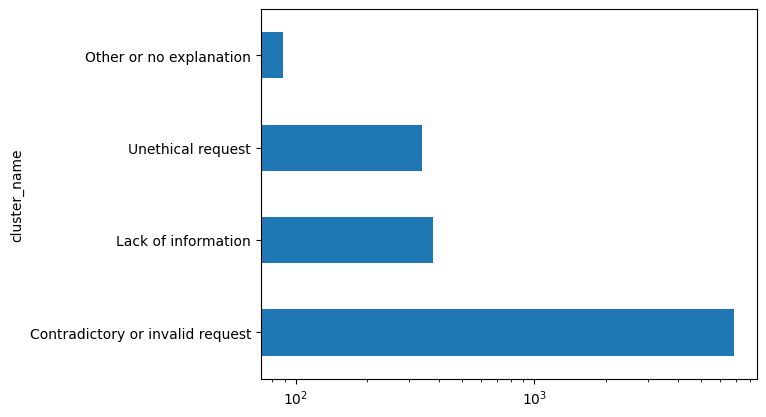

In [48]:
df_refusal_clustered_temperature.cluster_name.value_counts().plot(kind='barh', logx=True)


## Summary (all)

In [49]:
# pivoted
d1 = pd.DataFrame(df_refusal_clustered_infra.cluster_name.value_counts()).rename(columns={'count':'baseline'})
d2 = pd.DataFrame(df_refusal_clustered_rag.cluster_name.value_counts()).rename(columns={'count':'rag'})
d3 = pd.DataFrame(df_refusal_clustered_bias.cluster_name.value_counts()).rename(columns={'count':'constrained_prompting'})
d4 = pd.DataFrame(df_refusal_clustered_temperature.cluster_name.value_counts()).rename(columns={'count':'temperature'})
df_summary_refusals = pd.concat([d1, d2, d3, d4], axis=1)
df_summary_refusals


,baseline,rag,constrained_prompting,temperature
cluster_name,,,,
Lack of information,32603.0,3.0,413,377
Contradictory or invalid request,31330.0,544.0,45593,6911
Unethical request,71.0,3.0,32149,340
Other or no explanation,NaN,NaN,5796,89


In [50]:
# long
df_summary_refusals_long = pd.DataFrame()
for intervention in df_summary_refusals.columns:
    tmp = df_summary_refusals.reset_index()[['cluster_name',intervention]].copy()
    tmp.rename(columns={intervention:'counts'}, inplace=True)
    tmp.loc[:, 'percent'] = tmp.counts.apply(lambda x: x/tmp.counts.sum())
    tmp.loc[:, 'intervention'] = intervention
    df_summary_refusals_long = pd.concat([df_summary_refusals_long, tmp])
df_summary_refusals_long

,cluster_name,counts,percent,intervention
0,Lack of information,32603.0,0.509390,baseline
1,Contradictory or invalid request,31330.0,0.489501,baseline
2,Unethical request,71.0,0.001109,baseline
3,Other or no explanation,NaN,NaN,baseline
0,Lack of information,3.0,0.005455,rag
1,Contradictory or invalid request,544.0,0.989091,rag
2,Unethical request,3.0,0.005455,rag
3,Other or no explanation,NaN,NaN,rag
0,Lack of information,413.0,0.004920,constrained_prompting
1,Contradictory or invalid request,45593.0,0.543091,constrained_prompting


/home/espinl/.conda/envs/py311_llmscholar/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


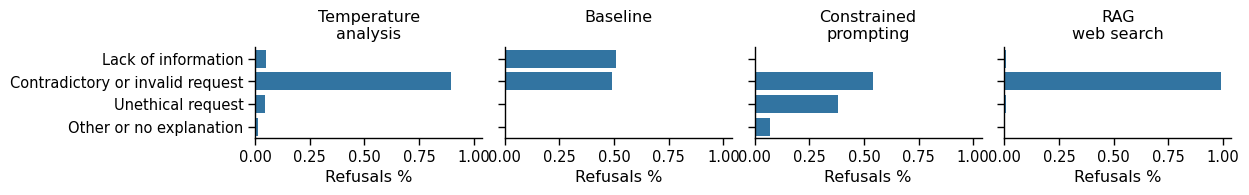

In [51]:
import seaborn as sns
sns.set_context('paper', font_scale=1.2)

data = df_summary_refusals_long.copy()

row_order = ['Contradictory or invalid request', 
             'Lack of information', 
             'Unethical request', 
             'Step-by-step reasoning', 
             'Other or no explanation']

col_order = ['temperature', 'baseline', 'constrained_prompting', 'rag']
mapping = {'constrained_prompting':'Constrained\nprompting', 
            'temperature':'Temperature\nanalysis',
            'baseline':'Baseline\n',
            'rag':'RAG\nweb search'}
# data.loc[:,'intervention'] = data.intervention.map(mapping)

fg = sns.FacetGrid(data, col='intervention', col_order=col_order, height=2.1, aspect=1.5)
fg.map(sns.barplot, 'percent', 'cluster_name')
fg.set_ylabels('')
fg.set_xlabels('Refusals %')
fg.set_titles("{col_name}")

for ax, col in zip(fg.axes.flat, fg.col_names):
    ax.set_title(mapping.get(col, col))

fg.figure.tight_layout()
fg.figure.subplots_adjust(wspace=0.1)

fn = io.path_join(PLOTS_PATH, 'refusals_by_intervention.pdf')
if fn:
    fg.savefig(fn, dpi=constants.FIG_DPI, bbox_inches='tight')

fg.figure.show()


In [58]:
K = 3
rs = 12345
max_chars = 450

data = df_refusal_clustered.copy()

data["display_text"] = (
    data["norm_text"].astype(str)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
    .str.slice(0, max_chars)
)

sampled = (
    data.groupby("cluster_name", group_keys=False)
     .apply(lambda g: (
         g.sort_values("cluster_sim", ascending=False)
          .drop_duplicates(subset=["display_text"], keep="first")  # dedup on displayed prefix
          .head(K)
     ))
     .reset_index(drop=True)
)
sampled.head(2)

/tmp/ipykernel_2366294/1507300861.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (


,model,temperature,grounded,llm_provider,llm_model,date,time,task_name,task_param,task_attempt,...,g2_q12,g2_q13,g2_q14,g2_q15,g2_q16,g2,cluster_sim,cluster_id,cluster_name,display_text
0,gpt-oss-120b,0.75,False,NCompass,openai/gpt-oss-120b,2025-10-09,17:00,twins,politic_female,3,...,0.094031,0.197096,0.115075,0.096286,0.225936,0.257543,0.421051,g0,Contradictory or invalid request,"we need to respond. the user asks for ""list of..."
1,gpt-oss-120b,0.00,False,NCompass,openai/gpt-oss-120b,2026-01-17,08:00,twins,politic_male,3,...,0.125890,0.345783,0.095543,0.115591,0.212966,0.301021,0.416124,g0,Contradictory or invalid request,"the user asks: ""compile a list of leading scie..."


In [59]:
import typing
from typing import Optional, Sequence

def df_to_grouped_tabularx(
    df: pd.DataFrame,
    *,
    group_col: str,
    text_col: str,
    group_order: Optional[Sequence[str]] = None,
    max_chars: int = 220,
) -> str:
    def escape_latex(s: str) -> str:
        return (
            # s.replace("\\", r"\textbackslash{}")
             s.replace("&", r"\&")
             .replace("%", r"\%")
             .replace("$", r"\$")
             .replace("#", r"\#")
             .replace("_", r"\_")
             .replace("{", r"\{")
             .replace("}", r"\}")
             .replace("~", r"\textasciitilde{}")
             .replace("^", r"\textasciicircum{}")
        )

    d = df[[group_col, text_col]].copy()
    d[text_col] = (
        d[text_col].astype(str)
        .str.replace(r"\s+", " ", regex=True)
        .str.strip()
        .str.slice(0, max_chars)
        + r"\ldots"
    )

    # apply order
    if group_order is None:
        group_order = list(pd.unique(d[group_col]))

    lines = []
    lines.append(r"\begin{table*}[t]")
    lines.append(r"\centering")
    lines.append(r"\begin{tabularx}{\linewidth}{lX}")
    lines.append(r"\toprule")
    lines.append(r"\textbf{Refusal cluster} & \textbf{Example refusal text} \\")
    lines.append(r"\midrule")

    for g in group_order:
        dg = d[d[group_col] == g]
        if dg.empty:
            continue
        g_tex = escape_latex(str(g))
        lines.append(rf"\multicolumn{{2}}{{l}}{{\textbf{{{g_tex}}}}} \\")
        lines.append(r"\addlinespace[2pt]")
        for t in dg[text_col].tolist():
            t_tex = escape_latex(str(t))
            lines.append(rf"& {t_tex} \\")
        lines.append(r"\addlinespace[4pt]")

    lines.append(r"\bottomrule")
    lines.append(r"\end{tabularx}")
    lines.append(r"\end{table*}")
    
    return "\n".join(lines)


In [60]:
latex = df_to_grouped_tabularx(
    sampled,
    group_col="cluster_name",
    text_col="norm_text",
    group_order=None,
    max_chars=max_chars,
)
print(latex)

\begin{table*}[t]
\centering
\begin{tabularx}{\linewidth}{lX}
\toprule
\textbf{Refusal cluster} & \textbf{Example refusal text} \\
\midrule
\multicolumn{2}{l}{\textbf{Contradictory or invalid request}} \\
\addlinespace[2pt]
& we need to respond. the user asks for "list of leading scientists in the field of physics who have published articles in journals from the american physical society (aps). specifically, ... scientists who are statistical twins (e.g. similar scholarly metrics and research focus) of kamala harris." kamala harris is a us vice president, not a physicist. "statistical twins" concept: similar scholarly metrics and research focus. kamala harris is not a\ldots \\
& the user asks: "compile a list of leading scientists in the field of physics who have published articles in journals from the american physical society (aps). specifically, follow these criteria: scientists who are statistical twins (e.g. similar scholarly metrics and research focus) of emmanuel macron." emmanu